In [1]:
SEED = 116

In [2]:
#autoload modules in notebook
%load_ext autoreload
%autoreload 2  

In [3]:
from itertools import combinations
import json
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, TFDistilBertModel
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import os
from itertools import islice
from collections import defaultdict

# import torch
import random

import pickle 
import CLIP_model
import CLIP_data_load
import utils
import numpy as np
import train_utils

2023-09-08 16:52:31.462994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 16:52:32.450057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ale/miniconda3/envs/tf2/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
from hyperparameters import *

print(f'Using random seed {SEED}...')
random.seed(SEED)
np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
tf.random.set_seed(SEED)

bert_model_name = 'distilbert-base-uncased' #bert-base-multilingual-uncased

# Paths
all_images_path = 'dataset/resized_train/'
dataset_extract_location = 'dataset/'
project_location = '.'
all_captions_path = f'{project_location}/dataset/caption_prediction_train.csv'  
all_concept_ids_path = f'{project_location}/dataset/concept_detection_train.csv'
all_concepts_path = f'{project_location}/dataset/concepts.csv'

zip_dataset_location = f'{project_location}/dataset/resized_train.zip'

Using random seed 116...


### Data load

In [5]:
# Merging all dataframes toghether into ID, caption, cuis, concepts
captionsDF = pd.read_csv(all_captions_path, sep="\t")
concept_id_df = pd.read_csv(all_concept_ids_path, sep="\t")
concept_df = pd.read_csv(all_concepts_path, sep=",")

captions_concepts_df = CLIP_data_load.preprocess_captions_concepts(
    captionsDF, concept_id_df, concept_df
)
captions_concepts_df = CLIP_data_load.remove_dark_images(
    captions_concepts_df, all_images_path=all_images_path, remove_images_threshold=0
)
captions_concepts_df.reset_index(inplace=True, drop=True)

[nltk_data] Downloading package stopwords to /home/ale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
train_val, test = train_test_split(captions_concepts_df, test_size = test_percentage, shuffle = True, random_state = SEED)
train, val = train_test_split(train_val, test_size = validation_percentage, shuffle = True, random_state = SEED)

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

testList = CLIP_data_load.paths_captions_concepts_emb_list(
    test,
    all_images_path,
    tokenizer=tokenizer,
    max_len_captions=captions_input_shape[0],
    max_len_concepts=concepts_input_shape[0]
)

100%|██████████| 16630/16630 [00:08<00:00, 2043.17it/s]


In [8]:
test_gen = CLIP_data_load.FusionGenerator(
    channels_first=False,
    preprocessing_function=None,
    data=testList,
    batch_size=batch_size,
    out_shape=img_shape[0:2],
    shuffle=False,
    model_version='base',
)

  0%|          | 0/2078 [00:00<?, ?it/s]

2023-09-08 16:53:19.780327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 16:53:19.966665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 16:53:19.966851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

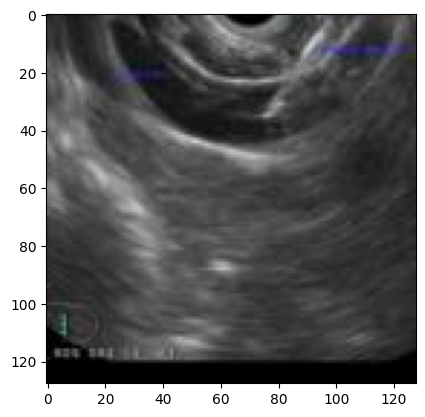

In [9]:
for i,(batch_image,batch_ids,batch_masks) in enumerate(tqdm(test_gen)):#8,64,64,3 and 8,512
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (img_size))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR to RGB
    plt.imshow(batch_image[0,:,:])
    break

## Load model

In [78]:
import wandb
model_to_use = 'clip_base_custom_loss_t0.15'
# model_to_use = 'clip_base_t0.2'

run = wandb.init(project="clip",name='inference_test')
artifact = run.use_artifact(f'calonca/clip/{model_to_use}:v0', type='model')
artifact_dir = artifact.download()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


num_classes,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
zero_shot_accuracy_test,█████▇▆▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
zero_shot_f1_macro,█████▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
zero_shot_f1_micro,█████▇▇▆▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
zero_shot_precision_macro,█████▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
zero_shot_precision_micro,▇▇▇███▇▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
zero_shot_recall_macro,███▇▇▆▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
zero_shot_recall_micro,███▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
num_classes,45
zero_shot_accuracy_test,0.10463
zero_shot_f1_macro,0.17688


wandb: Downloading large artifact clip_base_custom_loss_t0.15:v0, 337.69MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [79]:
bert_model = TFDistilBertModel.from_pretrained(bert_model_name)

model_loc = f"{artifact_dir}/{model_to_use}.h5"

loaded_model: CLIP_model.CLIP_base = tf.keras.models.load_model(
    model_loc,
    custom_objects={
        "TFDistilBertModel": bert_model,
        "CLIP_base": CLIP_model.CLIP_base,
        "ProjectorLayer": CLIP_model.ProjectorLayer
    },
    compile=False,
)  # type: ignore

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [80]:
def embed_img(batch_img):
  text_zeros = tf.zeros([batch_img.shape[0],*captions_input_shape])
  return embed(batch_img,text_zeros,text_zeros)[1]

def embed_txt(batch_ids,batch_att):
  image_zeros = tf.zeros([batch_ids.shape[0],*img_shape])
  return embed(image_zeros,batch_ids,batch_att)[0]

def embed(batch_img,batch_ids,batch_att):
    e_txt,e_img = loaded_model.predict_step((batch_img,batch_ids,batch_att))
    return e_txt.numpy(),e_img.numpy()

class PrecomputedEmbeddings:
    def __init__(self,emb_txt,emb_img,df):
        lenght = emb_txt.shape[0]
        self.ids = list(df['ID'])[:lenght]
        self.captions = list(df['caption'])[:lenght]
        self.concepts = list(df['concepts'])[:lenght]
        self.paths = [all_images_path+name for name in self.ids]
        self.text = emb_txt
        self.img = emb_img
        self.text_of = {id:text for id,text in zip(self.ids,self.text)}
        self.img_of = {id:img for id,img in zip(self.ids,self.img)}
        self.caption_of = {id:capt for id,capt in zip(self.ids,self.captions)}
    #len
    def __len__(self):
        return self.text.shape[0]
    
def get_precomputed_embeddings(save_path,data,force_recompute=False):
    if os.path.exists(save_path) and not force_recompute:
        with open(save_path, 'rb') as f:
            emb_data = pickle.load(f)
    else:
        e_txt, e_img = loaded_model.predict(data,workers=2)
        emb_data = PrecomputedEmbeddings(e_txt,e_img,test)
        with open(save_path, 'wb') as f:
            pickle.dump(emb_data, f)
    return emb_data

In [81]:
embed_test = get_precomputed_embeddings(f'{artifact_dir}/embed_test.pkl',test_gen,force_recompute=False)

In [82]:
# Print functions
def print_similar(id_simscore_tuples,embed_data,max_print_similar):

    similar = islice(reversed(id_simscore_tuples),0,max_print_similar)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def print_different(id_simscore_tuples,embed_data,max_print_different):

    reversed_vals = reversed(id_simscore_tuples[:max_print_different])
    for i,(id,v) in enumerate(reversed_vals):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def show_top_n_images(id_simscore_tuples,embeds, max_print):
    similar = islice(reversed(id_simscore_tuples),0,max_print)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embeds.caption_of[id]}")
        img_path = f'{all_images_path}{id}'
        #read color image
        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()

# Get functions

def get_similar_text(text,ids,embed_texts):  
  
    tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,captions_input_shape[0], return_tensors="tf")
    e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])
    
    distances_vals = np.dot(embed_texts,e_txt.T) #Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids,distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

def get_similar_images_from_text(text,ids,embed_imgs):  
  
  tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,captions_input_shape[0], return_tensors="tf")
  e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])

  distances_vals = np.dot(embed_imgs,e_txt.T) #Cosine similarity. The vectors are already normalized
  distances = dict(zip(ids,distances_vals))

  id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

  return id_simscore_tuples

def get_similar_images(image_name, ids, embed_imgs):
    image_path = f'{all_images_path}{image_name}.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    e_img = embed_img(image[None,:])

    distances_vals = np.dot(embed_imgs, e_img.T)  # Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids, distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

# Functions to call

def print_similar_text(query,embed_data,max_print_similar = 10,max_print_different = 10):
    """Retrive test using text to text similarity"""
    id_simscore_tuples = get_similar_text(query,embed_data.ids,embed_data.text)

    print_similar(id_simscore_tuples,embed_data,max_print_similar)

    print('...')

    print_different(id_simscore_tuples,embed_data,max_print_different)

def show_similar_images_from_path(image_name, embed_data, max_print_similar=10, max_print_different=10):
    """Retrive images using image to image similarity"""
    id_simscore_tuples = get_similar_images(image_name, embed_data.ids, embed_data.img)

    show_top_n_images(id_simscore_tuples, embed_data, max_print_similar)

    print_different(id_simscore_tuples,embed_data,max_print_different)


def show_similar_images_from_text(query,embeds,max_print_similar = 10,max_print_different = 10):
    """Retrive images given text using text to image similarity"""
    id_simscore_tuples = get_similar_images_from_text(query,embeds.ids,embeds.img)
    show_top_n_images(id_simscore_tuples,embeds, max_print_similar)

# Metrics

def new_rr(distances_vals,target_image_path, paths, n):
    
    full_dist = [paths[i] for i in np.argsort(distances_vals)[::-1]]

    distances =  full_dist[0:n]

    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    if target_image_path in distances:
        return 1/(distances.index(target_image_path) + 1)
    else:
        return 0

def compute_mrr(embed_data, n):
    collect_rr = []
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.

    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        path = embed_data.paths[i]
        newrr = new_rr(sim_matrix[i,:],path,embed_data.paths,n)
        # print(newrr)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)

def new_recall_at_k(distances_vals,target_image_id, ids, k):
    
    full_dist = [ids[i] for i in np.argsort(distances_vals)[::-1]]

    act_set = set([target_image_id])
    pred_set = set(full_dist[0:k])
    result = len(act_set & pred_set) / float(len(act_set)) # The & operator is used for the set intersection
    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    return result

def compute_recall_at_k(embed_data, k):
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.
    collect_rr = []
    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        id = embed_data.ids[i]
        newrr = new_recall_at_k(sim_matrix[i,:].T,id,embed_data.ids,k)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)

#show image from path
def show_image_from_path(name,pre='ImageCLEFmedCaption_2022_train'):
    """Show an image given the id"""
    img = cv2.imread(f'{all_images_path}/{pre}_{name}.jpg')
    plt.imshow(img)
    plt.show()

# Inference

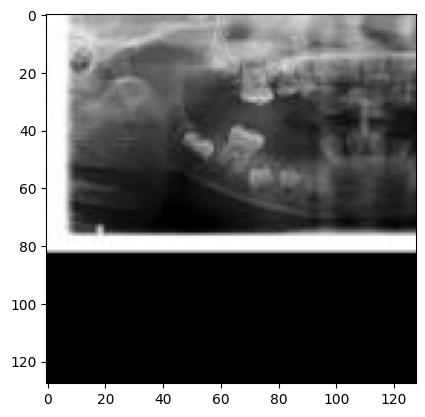

In [83]:
show_image_from_path('018446')

In [84]:
print_similar_text("opg",embed_test,max_print_similar = 10,max_print_different = 10)

ImageCLEFmedCaption_2022_train_006483.jpg [0.99999976] opg
ImageCLEFmedCaption_2022_train_005629.jpg [0.99999976] opg
ImageCLEFmedCaption_2022_train_019637.jpg [0.99999976] opg
ImageCLEFmedCaption_2022_train_069274.jpg [0.99999976] opg
ImageCLEFmedCaption_2022_train_066221.jpg [0.9988297] opg case
ImageCLEFmedCaption_2022_train_016058.jpg [0.998449] postoperative opg complete healing bony cavity sign relapse
ImageCLEFmedCaption_2022_train_007178.jpg [0.99840903] preoperative opg
ImageCLEFmedCaption_2022_train_005965.jpg [0.99840903] preoperative opg
ImageCLEFmedCaption_2022_train_011089.jpg [0.99840903] preoperative opg
ImageCLEFmedCaption_2022_train_017953.jpg [0.99840903] preoperative opg
...
ImageCLEFmedCaption_2022_train_004643.jpg [-0.24224703] case telemetry tracing ventricular fibrillation precede ventricular extrasystole
ImageCLEFmedCaption_2022_train_041226.jpg [-0.24224703] case telemetry tracing ventricular fibrillation precede ventricular extrasystole
ImageCLEFmedCaption_20

In [85]:
# print('Image -> Caption MRR@100 :', compute_mrr(embed_test, 100))
k = 100
# print(f'Image -> Caption   R@{k}:', compute_recall_at_k(embed_test, k))

ImageCLEFmedCaption_2022_train_016002.jpg 0.9999999403953552 posteroanterior cephalometric view right mandibular asymmetry


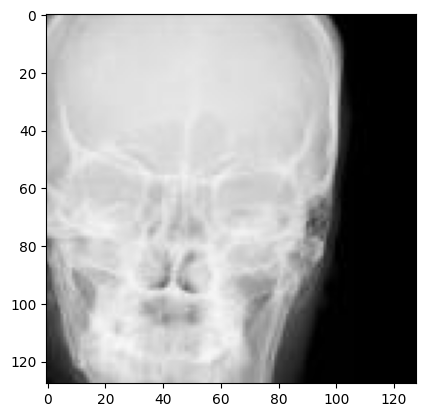

ImageCLEFmedCaption_2022_train_069172.jpg 0.978299081325531 periapical waters view haziness decrease size right maxillary sinus


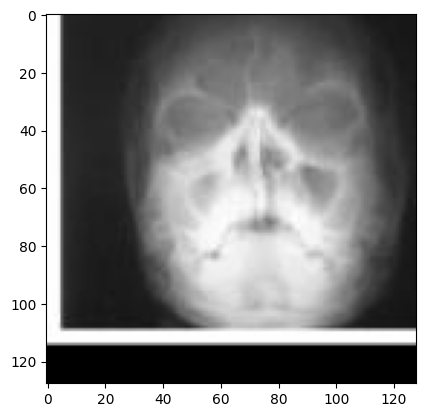

ImageCLEFmedCaption_2022_train_006845.jpg -0.24600189924240112 case electrocardiogram inferolateral early repolarization pattern jpoint elevation qrs slur hypothermia treatment red
ImageCLEFmedCaption_2022_train_054404.jpg -0.25268101692199707 preoperative computed tomography welldemarcate mass approximately feature consistent fibroadenoma observe low attenuation left axillary region denote asterisk mark computed tomography tomography


In [86]:
show_similar_images_from_path('ImageCLEFmedCaption_2022_train_016002',embed_test,max_print_similar = 2,max_print_different=2)

ImageCLEFmedCaption_2022_train_013897.jpg [0.899361] aggressive periodontitbe subject syndrome panoramic radiography man note bone loss mark two line severe extensive multiple tooth lose due periodontal dbeease


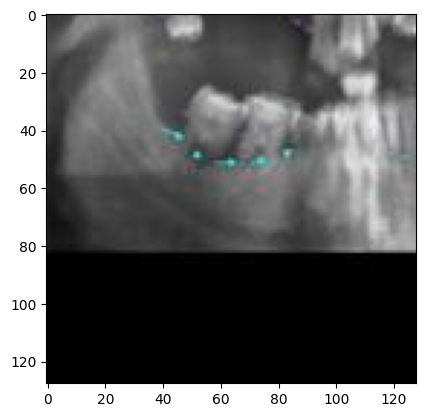

ImageCLEFmedCaption_2022_train_067707.jpg [0.8980896] postoperative orthopantomograph


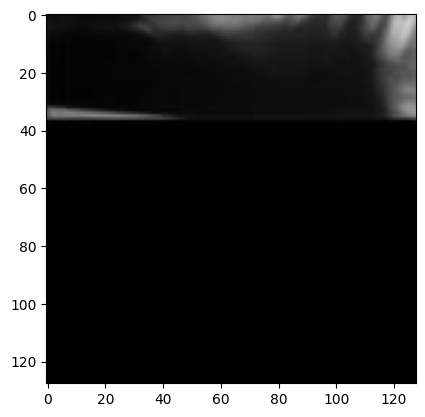

In [87]:
show_similar_images_from_text('opg',embed_test,max_print_similar=2)

### Multi class classification accuracy 

In [88]:
utils.print_metric(test,zs_num_classes)

(79829,) ['penicillin V' 'Ultrasonography' 'Estimated' ... 'Myocardial Infarction'
 'Right coronary artery structure' 'Magnetic Resonance Imaging']
total test samples: 16630
total concepts with duplicates: 79829
unique concepts: 6613
max concepts per sample: 111
min concepts per sample: 2
avg concepts per sample: 16.0131906951108

concepts of sample 0: {'penicillin V', 'Ultrasonography'}
concepts of sample 1: {'Estimated', 'Prostate', 'Ultrasonography', 'Enlarged'}
concepts of sample 2: {'Compressed structure', 'Cerebral Peduncle', 'Pituitary Adenoma', 'Magnetic Resonance Imaging'}
concepts of sample 3: {'Chest', 'X-Ray Computed Tomography'}
concepts of sample 4: {'Fusiform dilatation', 'Internal carotid artery structure', 'Plain x-ray', 'Tissue Dissection'}

most common concepts: 
[('X-Ray Computed Tomography', 5248), ('Plain x-ray', 4834), ('Magnetic Resonance Imaging', 2889), ('Ultrasonography', 2269), ('Chest', 1567), ('angiogram', 1178), ('Abdomen', 1160), ('Bone structure of cran

In [89]:
class LocalLogger():
    def __init__(self):
        self.allvalues = defaultdict(list)

    def log(self,name_value_dict={}):
        for k,v in name_value_dict.items():
            self.allvalues[k].append(v)

In [90]:
for zs_classes in range(2,46):
    _, tk_labels , one_hot_labels,  = train_utils.build_zero_shot_metric(
    test,
    tokenizer,
    concepts_input_shape[0],
    captions_input_shape[0],
    preceding_caption="An image of ",
    num_classes=zs_classes,
    )


    # local_logger = LocalLogger()

    emb_fun = lambda : embed_txt(tk_labels['input_ids'], tk_labels['attention_mask'])

    zero_shot_callback = train_utils.ZeroShotSingleLabelCallBack(
        model=loaded_model,
        gen=test_gen,
        zs_labels=one_hot_labels,
        logger=wandb,
        emb_fun=emb_fun,
        precomputed_e_img=embed_test.img,
    )   

    zero_shot_callback.on_epoch_end(None)
    # zs_acc= local_logger.allvalues['zero_shot_accuracy'][-1]
    # wandb.log({"zero_shot_test_accuracy":zs_acc,'zs_num_classes':zs_classes})
    # print(f"Zero shot accuracy for {zs_classes} classes: {zs_acc}")

/home/ale/miniconda3/envs/tf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ale/miniconda3/envs/tf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ale/miniconda3/envs/tf2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ale/miniconda3/envs/tf2/lib/python3.11/s

### functions from older zero shot setup

In [91]:
local_logger.allvalues

defaultdict(list, {'zero_shot_accuracy': [0.10462861989579547]})

In [92]:
# sample_labes has shape (num_samples,num_classes)
def add_other_class(samples_labels):
    # if a sample has only zeros concatenate a 1 at the end of the array
    # otherwise concatenate a 0
    other_class = np.array([1 if np.sum(sample) == 0 else 0 for sample in samples_labels])
    return np.concatenate((samples_labels,other_class[:,None]),axis=1)

In [93]:
similarity_treshold = 0.01 # Hyperparameter. Image that have similarity higher then the treshold will belong to the class

print(e_labels.shape)
#compute similarity between each image and label
similarities = np.dot( embed_test.img,e_labels.T)
one_hot_labels = np.array(embed_test.concepts)
#remove fourth class

sim_old = similarities.copy()
labels_old = one_hot_labels.copy()

similarities[similarities < similarity_treshold] = 0
similarities[similarities >= similarity_treshold] = 1

# print number of ones in each row of similarities
print(np.sum(similarities))
print(np.sum(one_hot_labels))


similarities = add_other_class(similarities)
one_hot_labels = add_other_class(one_hot_labels)

print(f'ground truth: {one_hot_labels}')
print(f'predictions: {similarities}')
# print(add_other_class(similarities))
# compute multi class metrics
print('Multi class accuracy:', accuracy_score(one_hot_labels, similarities))
# single class accuracy
one_hot_max_labels = one_hot_labels.argmax(axis=1)
max_one_hot_similarities = similarities.argmax(axis=1)


print('Single class accuracy:', accuracy_score(one_hot_max_labels, max_one_hot_similarities))

matrix = confusion_matrix(one_hot_max_labels, sim_old.argmax(axis=1),normalize='true')
print('Single class confusion matrix:')
#plot matrix
plt.figure(figsize=(8,8))
lb = concepts# + ['other']
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=lb, yticklabels=lb)
# add x and y labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multi label confusion matrix
matrix = multilabel_confusion_matrix(one_hot_labels, similarities)
print(matrix[0])
print(matrix[1])
print(matrix[2])
# plot confusion matrix for each class
for i in range(num_classes):
    #plot matrix
    plt.figure(figsize=(2,2))
    #set title to class name
    plt.title(lb[i])
    xlb = ['pred F','pred T']
    ylb = ['F','T']
    mat = matrix[i]/np.linalg.norm(matrix[i])
    # cut numbers with more than 2 decimals
    sns.heatmap(mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=xlb, yticklabels=ylb)
    print()

NameError: name 'e_labels' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def find_best_treshold(similarities, one_hot_labels):
    best_treshold = 0
    best_acc = 0
    sim_copy = similarities.copy()
    progress = tqdm(np.arange(0, 1, 0.01))
    acc_values = []  # list to store accuracy values for each threshold
    for treshold in progress:
        similarities = sim_copy.copy()
        similarities[similarities < treshold] = 0
        similarities[similarities >= treshold] = 1
        acc = accuracy_score(one_hot_labels, similarities)
        acc_values.append(acc)  # add accuracy value to list
        if acc > best_acc:
            best_acc = acc
            best_treshold = treshold
            progress.set_description(f"Best treshold: {best_treshold}, Best acc: {best_acc}")
    # plot accuracy values
    plt.plot(np.linspace(0, 1, num=len(acc_values)), acc_values)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.show()
    plt.close()
    return best_treshold, best_acc

similarities = np.dot(embed_test.img, e_labels.T)
one_hot_labels = np.array(embed_test.concepts)
best_treshold, best_acc = find_best_treshold(similarities, one_hot_labels)

In [ ]:
#print predicted classes abor the treshold for each sample
tc = test.copy().reset_index(drop=True)
for i, (id,caption,cuis,concepts) in tc.iterrows():
    if i >= len(embed_test):
        break
    # get image embedding
    img = embed_test.img_of[id]
    # compute similarity between image and labels
    similarities = np.dot( img,e_labels.T)
    # get predicted labels
    predicted_labels = [concepts[i] for i in np.where(similarities > best_treshold)[0]]
    concept_with_labels_removed = [concept for concept in concepts if concept in concepts]
    print(f'predicted labels: {predicted_labels}')
    print(f'ground truth    : {concept_with_labels_removed}')
    print()
    print(i)

